In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta, date
from humanize import naturalsize
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Qiita's resource allocation

This notebook walks through how to load & parse the job stats from Qiita. It additionally tries to split the different commands by their resource utilization and make sure to be as accurate/fair to request them. Here resource allocations are mainly walltime (`ElapsedRawTime`), memory (`MaxRSSRaw`) and the time a job took to start running (`WaitTime`: Start - Submit). 

# Loading data

First you will need to run `generate-allocation-summary.py` in Qiita as the qiita user (or whatever user runs qiita in your system). The resulting file would be: `job_[date].tsv.gz`.

The generated file will have these columns: `['JobID', 'ElapsedRaw', 'MaxRSS', 'Submit', 'Start', 'MaxRSS.1', 'CPUTimeRAW', 'ReqMem', 'AllocCPUS', 'AveVMSize', 'QiitaID', 'external_id', 'sId', 'sName', 'sVersion', 'cId', 'cName', 'samples', 'columns', 'input_size', 'extra_info'],`.

In [2]:
m1g = 2**30
df = pd.read_csv('jobs_2023-10-04.tsv.gz', sep='\t', dtype={'extra_info': str})
df['ElapsedRawTime'] = pd.to_timedelta(df.ElapsedRawTime)

In [3]:
# for reference for the next iteration of this notebook
f'There are {df.shape[0]} successful jobs since we moved to barnacle2 and the largest external_id is: {df.external_id.max()}'

'There are 101147 successful jobs since we moved to barnacle2 and the largest external_id is: 1581986'

# Main summary

Just showing the first 15, this is helpful to see the huge differences between before and after the first set of changes were made.

In [4]:
# discarding jobs before 1265533; this is so we only keep the most recent; 
# the main reasons for that are discussed in the 072023 notebook (in this same section)
df = df[df.external_id >= 1265533].copy()

summary = df.groupby(['cName', 'sName'])[
    ['ElapsedRawTime', 'MaxRSSRaw', 'WaitTime']].agg(['count', 'min', 'max']).copy()
summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)
summary.drop(columns=[('WaitTime', 'count')], inplace=True)
summary.drop(columns=[('MaxRSSRaw', 'count')], inplace=True)
summary.sort_values(('ElapsedRawTime', 'count'), inplace=True, ascending=False)
print('Total unique jobs:', summary.shape[0])
pd.set_option('display.max_rows', len(summary))
display(summary)
pd.reset_option('display.max_rows')

Total unique jobs: 66


ElapsedRawTime  \
                                                                                                      count   
cName                                              sName                                                      
complete_job                                       Qiita                                              16590   
release_validators                                 Qiita                                               5520   
Validate                                           BIOM type - BIOM                                    4503   
                                                   Visualization types - q2_visualization              1542   
                                                   Sequencing Data Type - Demultiplexed                 765   
                                                   Sequencing Data Type - per_sample_FASTQ              750   
update_sample_template                             Qiita                                                687   
Validate                                           Diversity types - distance_matrix                    669   
Beta diversity group significance [beta_group_s... qiime2                                               596   
Validate                                           Diversity types - alpha_vector                       543   
Pick closed-reference OTUs                         QIIMEq2                                              517   
Trimming                                           QIIMEq2                                              517   
Validate                                           Diversity types - ordination_results                 502   
Deblur 2021.09                                     deblur                                               481   
delete_artifact                                    Qiita                                                472   
Filter samples from table [filter_samples]         qiime2                                               371   
build_analysis_files                               Qiita                                                316   
adonis PERMANOVA test for beta group significan... qiime2                                               308   
Beta diversity (phylogenetic) [beta_phylogenetic]  qiime2                                               289   
Split libraries FASTQ                              QIIMEq2                                              249   
Principal Coordinate Analysis [pcoa]               qiime2                                               241   
create_sample_template                             Qiita                                                231   
Visualize taxonomy with an interactive bar plot... qiime2                                               189   
Alpha diversity [alpha]                            qiime2                                               168   
delete_sample_or_column                            Qiita                                                136   
Rarefy table [rarefy]                              qiime2                                               135   
delete_analysis                                    Qiita                                                126   
Beta diversity [beta]                              qiime2                                               109   
Sequence Processing Pipeline                       qp-klp                                               100   
Validate                                           qtp-job-output-folder - job-output-folder            100   
                                                   Sequencing Data Type - FASTQ                          87   
Alpha diversity (phylogenetic) [alpha_phylogene... qiime2                                                72   
Validate                                           Diversity types - FeatureData                         72   
Apply ANCOM to identify features that differ in... qiime2                                        

# Deciding what to optimize and what to leave with a default value

In the previous version (072023) we decided to only optimize things that are using more than 4gb or 4hrs

In [5]:
summary = df.groupby(['cName', 'sName'])[
        ['ElapsedRawTime', 'MaxRSSRaw']].agg(['count', 'min', 'max']).copy()

# We are gonna focus on jobs that request more than 4gb or take more than 4hrs.
summary = summary[(summary[('MaxRSSRaw', 'max')] > 4*m1g) | 
                  (summary[('ElapsedRawTime', 'max')] > timedelta(hours=4))]

summary.sort_values(('MaxRSSRaw', 'count'), inplace=True, ascending=False)

summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)
summary.drop(columns=[('MaxRSSRaw', 'count')], inplace=True)

_df = summary[summary.index.get_level_values('sName') != 'qiime2']
print ("qiita:", _df.shape[0])
display(_df)

_df = summary[summary.index.get_level_values('sName') == 'qiime2']
print ("qiime2:", _df.shape[0])
display(_df)

qiita: 15


ElapsedRawTime  \
                                                                              count   
cName                        sName                                                    
release_validators           Qiita                                             5520   
Validate                     BIOM type - BIOM                                  4503   
                             Sequencing Data Type - Demultiplexed               765   
                             Sequencing Data Type - per_sample_FASTQ            750   
update_sample_template       Qiita                                              687   
Validate                     Diversity types - distance_matrix                  669   
                             Diversity types - alpha_vector                     543   
Trimming                     QIIMEq2                                            517   
Pick closed-reference OTUs   QIIMEq2                                            517   
Deblur 2021.09               deblur                                             481   
build_analysis_files         Qiita                                              316   
Split libraries FASTQ        QIIMEq2                                            249   
delete_sample_or_column      Qiita                                              136   
Sequence Processing Pipeline qp-klp                                             100   
submit_to_EBI                Qiita                                               31   

                                                                                      \
                                                                                 min   
cName                        sName                                                     
release_validators           Qiita                                   0 days 00:00:06   
Validate                     BIOM type - BIOM                        0 days 00:01:01   
                             Sequencing Data Type - Demultiplexed    0 days 00:00:36   
                             Sequencing Data Type - per_sample_FASTQ 0 days 00:00:38   
update_sample_template       Qiita                                   0 days 00:00:03   
Validate                     Diversity types - distance_matrix       0 days 00:00:38   
                             Diversity types - alpha_vector          0 days 00:01:15   
Trimming                     QIIMEq2                                 0 days 00:00:39   
Pick closed-reference OTUs   QIIMEq2                                 0 days 00:04:24   
Deblur 2021.09               deblur                                  0 days 00:02:17   
build_analysis_files         Qiita                                   0 days 00:01:23   
Split libraries FASTQ        QIIMEq2                                 0 days 00:00:50   
delete_sample_or_column      Qiita                                   0 days 00:00:03   
Sequence Processing Pipeline qp-klp                                  0 days 00:02:25   
submit_to_EBI                Qiita                                   0 days 00:04:32   

                                                                                      \
                                                                                 max   
cName                        sName                                                     
release_validators           Qiita                                   6 days 09:07:42   
Validate                     BIOM type - BIOM                        0 days 05:58:41   
                             Sequencing Data Type - Demultiplexed    1 days 16:56:48   
                             Sequencing Data Type - per_sample_FASTQ 0 days 04:12:47   
update_sample_template       Qiita                                   0 days 00:33:08   
Validate                     Diversity types - distance_matrix       0 days 00:08:06   
                             Diversity types - alpha_vector          0 days 05:00:08   
Trimming                     QIIMEq2 

qiime2: 9


ElapsedRawTime  \
                                                                   count   
cName                                              sName                   
Filter samples from table [filter_samples]         qiime2            371   
Beta diversity (phylogenetic) [beta_phylogenetic]  qiime2            289   
Rarefy table [rarefy]                              qiime2            135   
Alpha diversity (phylogenetic) [alpha_phylogene... qiime2             72   
Apply ANCOM to identify features that differ in... qiime2             67   
Pre-fitted sklearn-based taxonomy classifier [c... qiime2             58   
Alpha rarefaction curves [alpha_rarefaction]       qiime2             35   
Filter features against reference [filter_featu... qiime2             27   
Visualize and Interact with Principal Coordinat... qiime2             26   

                                                                           \
                                                                      min   
cName                                              sName                    
Filter samples from table [filter_samples]         qiime2 0 days 00:00:57   
Beta diversity (phylogenetic) [beta_phylogenetic]  qiime2 0 days 00:01:04   
Rarefy table [rarefy]                              qiime2 0 days 00:00:55   
Alpha diversity (phylogenetic) [alpha_phylogene... qiime2 0 days 00:01:08   
Apply ANCOM to identify features that differ in... qiime2 0 days 00:01:14   
Pre-fitted sklearn-based taxonomy classifier [c... qiime2 0 days 00:01:41   
Alpha rarefaction curves [alpha_rarefaction]       qiime2 0 days 00:15:45   
Filter features against reference [filter_featu... qiime2 0 days 00:02:07   
Visualize and Interact with Principal Coordinat... qiime2 0 days 00:01:20   

                                                                           \
                                                                      max   
cName                                              sName                    
Filter samples from table [filter_samples]         qiime2 0 days 00:24:35   
Beta diversity (phylogenetic) [beta_phylogenetic]  qiime2 0 days 00:13:55   
Rarefy table [rarefy]                              qiime2 0 days 00:35:37   
Alpha diversity (phylogenetic) [alpha_phylogene... qiime2 0 days 00:05:28   
Apply ANCOM to identify features that differ in... qiime2 1 days 07:50:45   
Pre-fitted sklearn-based taxonomy classifier [c... qiime2 0 days 08:04:39   
Alpha rarefaction curves [alpha_rarefaction]       qiime2 1 days 13:21:15   
Filter features against reference [filter_featu... qiime2 0 days 00:18:52   
Visualize and Interact with Principal Coordinat... qiime2 0 days 00:10:50   

                                                          MaxRSSRaw           
                                                                min      max  
cName                                              sName                      
Filter samples from table [filter_samples]         qiime2  241.2 MB  24.8 GB  
Beta diversity (phylogenetic) [beta_phylogenetic]  qiime2  241.2 MB  13.5 GB  
Rarefy table [rarefy]                              qiime2   79.2 MB  12.3 GB  
Alpha diversity (phylogenetic) [alpha_phylogene... qiime2  231.0 MB  13.3 GB  
Apply ANCOM to identify features that differ in... qiime2  244.5 MB   5.2 GB  
Pre-fitted sklearn-based taxonomy classifier [c... qiime2  938.3 MB  44.4 GB  
Alpha rarefaction curves [alpha_rarefaction]       qiime2  206.7 MB   2.8 GB  
Filter features against reference [filter_featu... qiime2    8.8 GB  11.1 GB  
Visualize and Interact with Principal Coordinat... qiime2  243.3 MB  25.1 GB

## Optimizing Qiita processing jobs.

As a remider, we can use:
- 'samples'
- 'columns'
- 'input_size'
- 'extra_info': this is when the current method doesn't provide the required info or we need to update it; this info comes from `job_stats_generation.py`

Note that `COMPLETE_JOBS_RESOURCE_PARAM` and `RELEASE_VALIDATORS_RESOURCE_PARAM` are not in the list but is the most common job; thus optimizing it

#### Complete jobs 

In [6]:
# COMPLETE_JOBS_RESOURCE_PARAM
cmd = 'complete_job'
summary = df[df.cName == cmd].groupby(
    ['cName', 'sName', 'extra_info'], dropna=False)[
    ['ElapsedRawTime', 'MaxRSSRaw', 'WaitTime']].agg(['count', 'min', 'max']).copy()
summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)
summary.drop(columns=[('MaxRSSRaw', 'count')], inplace=True)
summary.drop(columns=[('WaitTime', 'count')], inplace=True)
summary.sort_values(('ElapsedRawTime', 'max'), inplace=True, ascending=False)

display(summary.head(10))

# The current allocation for all complete jobs is (from 072023)
# COMPLETE_JOBS_RESOURCE_PARAM |
#     default           | -p qiita -N 1 -n 1 --mem 500mb --time 00:20:00 --qos=qiita_prio
#     per_sample_FASTQ  | -p qiita -N 1 -n 1 --mem 200mb --time 15:00:00 --qos=qiita_prio
#     FASTQ             | -p qiita -N 1 -n 1 --mem 200mb --time 1:30:00 --qos=qiita_prio
#     job-output-folder | -p qiita -N 1 -n 1 --mem 200mb --time 1:00:00 --qos=qiita_prio

# No changes needed! 

ElapsedRawTime  \
                                                                               count   
cName        sName extra_info                                                          
complete_job Qiita FASTQ                                                          87   
                   per_sample_FASTQ                                              893   
                   BIOM                                                         6702   
                   NaN                                                          1404   
                   q2_visualization                                             2837   
                   Demultiplexed                                                1565   
                   distance_matrix                                              1090   
                   alpha_vector,ordination_results,q2_visualizatio...             91   
                   ordination_results                                            756   
                   alpha_vector                                                  796   

                                                                                       \
                                                                                  min   
cName        sName extra_info                                                           
complete_job Qiita FASTQ                                              0 days 00:00:04   
                   per_sample_FASTQ                                   0 days 00:00:03   
                   BIOM                                               0 days 00:00:02   
                   NaN                                                0 days 00:00:03   
                   q2_visualization                                   0 days 00:00:03   
                   Demultiplexed                                      0 days 00:00:03   
                   distance_matrix                                    0 days 00:00:03   
                   alpha_vector,ordination_results,q2_visualizatio... 0 days 00:00:05   
                   ordination_results                                 0 days 00:00:03   
                   alpha_vector                                       0 days 00:00:03   

                                                                                       \
                                                                                  max   
cName        sName extra_info                                                           
complete_job Qiita FASTQ                                              0 days 02:38:35   
                   per_sample_FASTQ                                   0 days 02:27:09   
                   BIOM                                               0 days 00:14:07   
                   NaN                                                0 days 00:08:54   
                   q2_visualization                                   0 days 00:05:44   
                   Demultiplexed                                      0 days 00:05:39   
                   distance_matrix                                    0 days 00:03:46   
                   alpha_vector,ordination_results,q2_visualizatio... 0 days 00:03:25   
                   ordination_results                                 0 days 00:03:23   
                   alpha_vector                                       0 days 00:03:00   

                                                                      MaxRSSRaw  \
                                                                            min   
cName        sName extra_info                                                     
complete_job Qiita FASTQ                                                0 Bytes   
                   per_sample_FASTQ                                     0 Bytes   
                   BIOM                                                 0 Bytes   
                   NaN                                                  0 Bytes   
                   q2_visual

#### Release validator jobs

In [7]:
# RELEASE_VALIDATORS_RESOURCE_PARAM
cmd = 'release_validators'
_df = df[(df.cName == cmd) & (df.updated == 'after')].copy()
summary = _df.groupby(
    ['cName', 'sName', 'extra_info'], dropna=False)[
    ['ElapsedRawTime', 'MaxRSSRaw']].agg(['count', 'min', 'max']).copy()
summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)
summary.sort_values(('ElapsedRawTime', 'max'), inplace=True, ascending=False)
summary.drop(columns=[('MaxRSSRaw', 'count')], inplace=True)

print(summary.shape[0])
display(summary.head(11))

# The current allocations are:
#    default                                                | -p qiita -N 1 -n 1 --mem 200mb --time 4:00:00
#    Core diversity metrics (non-phylogenetic) [core_metrics]
#          -p qiita -N 1 -n 1 --mem 150mb --time 6-15:00:00
#    Core diversity metrics (phylogenetic and non-phylogenetic) [core_metrics_phylogenetic]
#          -p qiita -N 1 -n 1 --mem 150mb --time 2-9:00:00
#    Beta diversity (phylogenetic) [beta_phylogenetic]      | -p qiita -N 1 -n 1 --mem 150mb --time 18:00:00
#    Alpha diversity (phylogenetic) [alpha_phylogenetic]    | -p qiita -N 1 -n 1 --mem 150mb --time 19:00:00
#    Beta diversity [beta]                                  | -p qiita -N 1 -n 1 --mem 150mb --time 18:00:00
#    Alpha diversity [alpha]                                | -p qiita -N 1 -n 1 --mem 150mb --time 16:00:00
#    Deblur 2021.09                                         | -p qiita -N 1 -n 1 --mem 150mb --time 11:00:00
#    Adapter and host filtering                             | -p qiita -N 1 -n 1 --mem 200mb --time 6:30:00
#    Trimming                                               | -p qiita -N 1 -n 1 --mem 150mb --time 5:00:00

# *** RESOURCE ALLOCATION ***
# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 --mem 150mb --time 1-17:00:00'
#     WHERE job_type = 'RELEASE_VALIDATORS_RESOURCE_PARAM' and 
#     name = 'Alpha diversity [alpha]';

42


ElapsedRawTime  \
                                                                                     count   
cName              sName extra_info                                                          
release_validators Qiita Core diversity metrics (non-phylogenetic) [core...             48   
                         Core diversity metrics (phylogenetic and non-ph...             43   
                         Alpha diversity [alpha]                                       174   
                         Woltka v0.1.4                                                 493   
                         Deblur 2021.09                                                490   
                         Trimming                                                      518   
                         Beta diversity (phylogenetic) [beta_phylogenetic]             289   
                         Alpha diversity (phylogenetic) [alpha_phylogene...             73   
                         Beta diversity [beta]                                         109   
                         Adapter and host filtering                                    105   
                         Pick closed-reference OTUs                                    517   

                                                                                             \
                                                                                        min   
cName              sName extra_info                                                           
release_validators Qiita Core diversity metrics (non-phylogenetic) [core... 0 days 00:03:58   
                         Core diversity metrics (phylogenetic and non-ph... 0 days 00:05:45   
                         Alpha diversity [alpha]                            0 days 00:01:26   
                         Woltka v0.1.4                                      0 days 00:00:14   
                         Deblur 2021.09                                     0 days 00:00:19   
                         Trimming                                           0 days 00:00:21   
                         Beta diversity (phylogenetic) [beta_phylogenetic]  0 days 00:00:06   
                         Alpha diversity (phylogenetic) [alpha_phylogene... 0 days 00:01:39   
                         Beta diversity [beta]                              0 days 00:00:46   
                         Adapter and host filtering                         0 days 00:00:45   
                         Pick closed-reference OTUs                         0 days 00:00:09   

                                                                                             \
                                                                                        max   
cName              sName extra_info                                                           
release_validators Qiita Core diversity metrics (non-phylogenetic) [core... 6 days 09:07:42   
                         Core diversity metrics (phylogenetic and non-ph... 2 days 07:53:10   
                         Alpha diversity [alpha]                            1 days 16:14:27   
                         Woltka v0.1.4                                      1 days 02:56:54   
                         Deblur 2021.09                                     1 days 02:45:59   
                         Trimming                                           0 days 22:24:10   
                         Beta diversity (phylogenetic) [beta_phylogenetic]  0 days 17:26:18   
                         Alpha diversity (phylogenetic) [alpha_phylogene... 0 days 17:17:40   
                         Beta diversity [beta]                              0 days 16:53:16   
                         Adapter and host filtering                         0 days 06:09:46   
                         Pick closed-reference OTUs                         0 days 05:40:20   

                                                                            MaxRSSRaw  \
        

#### Validate jobs 

These are based on the artifact_type they are validating, which is part of the job submission and is being
added as part of the software name here

In [8]:
# RELEASE_VALIDATORS_RESOURCE_PARAM
cmd = 'Validate'
# & (df.updated == 'after')
_df = df[(df.cName == cmd)].copy()
summary = _df.groupby(
    ['cName', 'sName'], dropna=False)[
    ['ElapsedRawTime', 'MaxRSSRaw']].agg(['count', 'min', 'max']).copy()

summary = summary[(summary[('MaxRSSRaw', 'max')] > 1*m1g) | 
                  (summary[('ElapsedRawTime', 'max')] > timedelta(hours=1))]

summary[('MaxRSSRaw', 'min')] = summary[('MaxRSSRaw', 'min')].apply(naturalsize)
summary[('MaxRSSRaw', 'max')] = summary[('MaxRSSRaw', 'max')].apply(naturalsize)
summary.sort_values([('ElapsedRawTime', 'max'), ('MaxRSSRaw', 'max')], inplace=True, ascending=False)
summary.drop(columns=[('MaxRSSRaw', 'count')], inplace=True)

display(summary)

ElapsedRawTime  \
                                                          count   
cName    sName                                                    
Validate Sequencing Data Type - Demultiplexed               765   
         BIOM type - BIOM                                  4503   
         Diversity types - alpha_vector                     543   
         Sequencing Data Type - per_sample_FASTQ            750   
         Sequencing Data Type - FASTQ                        87   
         Diversity types - ordination_results               502   
         Diversity types - distance_matrix                  669   

                                                                  \
                                                             min   
cName    sName                                                     
Validate Sequencing Data Type - Demultiplexed    0 days 00:00:36   
         BIOM type - BIOM                        0 days 00:01:01   
         Diversity types - alpha_vector          0 days 00:01:15   
         Sequencing Data Type - per_sample_FASTQ 0 days 00:00:38   
         Sequencing Data Type - FASTQ            0 days 00:00:41   
         Diversity types - ordination_results    0 days 00:00:37   
         Diversity types - distance_matrix       0 days 00:00:38   

                                                                 MaxRSSRaw  \
                                                             max       min   
cName    sName                                                               
Validate Sequencing Data Type - Demultiplexed    1 days 16:56:48   83.4 MB   
         BIOM type - BIOM                        0 days 05:58:41  125.8 MB   
         Diversity types - alpha_vector          0 days 05:00:08  186.8 MB   
         Sequencing Data Type - per_sample_FASTQ 0 days 04:12:47   77.4 MB   
         Sequencing Data Type - FASTQ            0 days 01:50:44   77.9 MB   
         Diversity types - ordination_results    0 days 00:12:54   74.8 MB   
         Diversity types - distance_matrix       0 days 00:08:06    1.6 MB   

                                                            
                                                       max  
cName    sName                                              
Validate Sequencing Data Type - Demultiplexed      15.6 GB  
         BIOM type - BIOM                         329.2 GB  
         Diversity types - alpha_vector             9.4 GB  
         Sequencing Data Type - per_sample_FASTQ   88.7 MB  
         Sequencing Data Type - FASTQ              84.4 MB  
         Diversity types - ordination_results       2.1 GB  
         Diversity types - distance_matrix          5.4 GB

BIOM type - BIOM    4
Name: sName, dtype: int64

Sequencing Data Type - Demultiplexed    6
Name: sName, dtype: int64

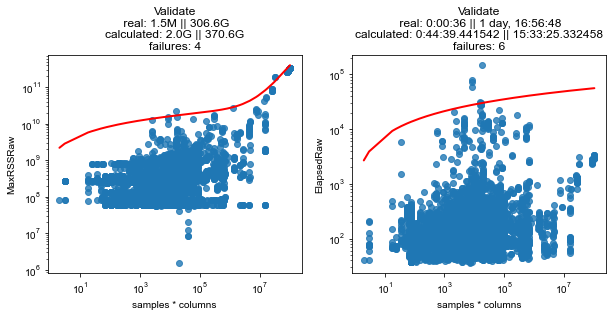

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Validate'
_df = df[df.cName == cname].copy()
# fine to dropna as that means that the study or the analysis 
# don't exist anymore AKA not useful
_df.dropna(subset=['samples', 'columns'], inplace=True)

col_name = 'samples * columns'
_df[col_name] = _df.samples * _df['columns']

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = m1g + (np.log(x_plot)*m1g*1.5) + (x_plot*3500)
_df['cMaxRSSRaw'] = m1g + (np.log(_df[col_name])*m1g*1.5) + (_df[col_name]*3500)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures_df = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures_df.shape[0]
display(failures_df.sName.value_counts())

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 600 + (np.log(x_plot)*3000)
_df['cElapsedRaw'] = 600 + (np.log(_df[col_name])*3000)
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures_df = _df[_df.ElapsedRaw > _df.cElapsedRaw]
failures = failures_df.shape[0]
display(failures_df.sName.value_counts())

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

col_name = 'samples * columns'
_df[col_name] = _df.samples * _df['columns']

# Current allocation:
#    '-p qiita -N 1 -n 1 '
#            || '--mem (2**30)+(nlog({samples}*{columns})*(2**30)*1.5)+({samples}*{columns}*3500) '
#            || '--time 600+(nlog({samples}*{columns})*3000)' 
#     

# No changes needed! 

# Note, in this iterations there are more failures than the last time but
# as far as I can tell, the failures are due to EBI-ENA loaded studies, 
# we should consider lowering the max number of samples per-preparation
# that qebil loads from 250 to 150.

### build_analysis_files

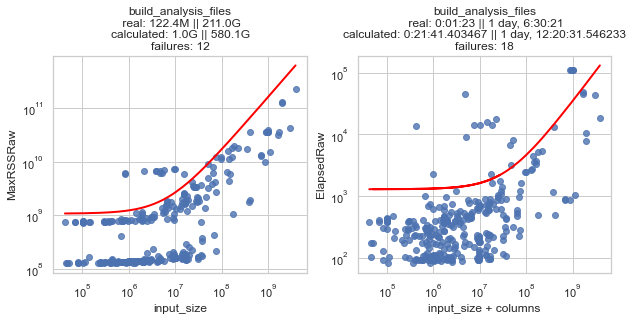

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'build_analysis_files'
_df = df[df.cName == cname].copy()

# convert extra_info, which is the same as input_size but counting only biom

col_name = 'input_size'

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = m1g + (x_plot*160)
_df['cMaxRSSRaw'] = m1g + (_df[col_name]*160)
failures_df = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures_df.shape[0]

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

col_name = 'input_size + columns'
_df[col_name] = _df['input_size'] + _df['columns']

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 1300 + (x_plot/30000)
_df['cElapsedRaw'] = 1300 + (_df[col_name]/30000)
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures_df = _df[_df.ElapsedRaw > _df.cElapsedRaw]
failures = failures_df.shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# Current allocation:
#    '-p qiita -N 1 -n 1 '
#            || '--mem (2**30)+({input_size}*160)'
#            || '--time 1300+(({input_size}+{columns})/30000)'

# No changes needed! 

# => NOTES from 072023
# the jobs outside due to
#  - memory are due to odd combinations of selections
#  - walltime are because they include waiting for validators

# The spike on resources might be the number of tips or filtering based 
# on the deblur tree

In [11]:
#### Testing values here 
# (let's ignore this block for now but it will be important in the next round)?

# _df = df[
#     (df.cName == cname)
#     & (df.updated == 'after')
# ].copy()
# col_name = 'input_size'
# x_plot = np.array(sorted(_df[col_name].unique()))
# _df['cMaxRSSRaw'] = m1g + (_df[col_name]*160)
# failures_df = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]

# display(failures_df[['JobID', 'QiitaID']])
# display(failures_df.QiitaID.to_list())

# formula = '2**30+({input_size}*{samples}*6)'
# samples, columns, input_size = 451, 51, 2345108
# formula = formula.format(samples=samples, columns=columns, input_size=input_size)
# value = eval(formula)
# print (formula, value, naturalsize(value, gnu=True, format='%.0f'))

### Pick closed-reference OTUs

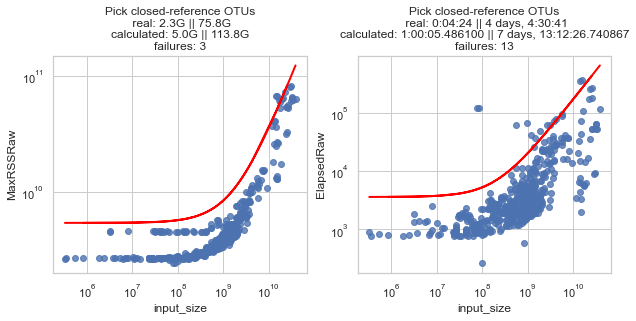

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Pick closed-reference OTUs'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()
col_name = 'input_size'

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (5*m1g)+(x_plot*3)
_df['cMaxRSSRaw'] = (5*m1g)+(_df[col_name]*3)

failures_df = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures_df.shape[0]

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')


# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 3600+(x_plot/60000)
_df['cElapsedRaw'] = 3600+(_df[col_name]/60000)
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

failures_df = _df[_df.ElapsedRaw > _df.cElapsedRaw]
failures = failures_df.shape[0]

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# Current allocation:
#    '-p qiita -N 1 -n 1 '
#            || '--mem (5*(2**30))+({input_size}*3)'
#            || '--time 3600+({input_size}/60000)'

# No changes needed! 

# Similar to Split Libraries and Deblur the out of range jobs are mainly
# EBI-ENA imported jobs

### Trimming

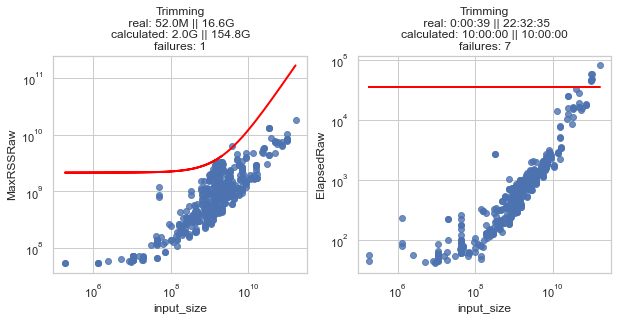

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Trimming'
_df = df[(df.cName == cname)
          & (df.updated == 'after')
         ].copy()
col_name = 'input_size'
_df[col_name] = _df.input_size

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
# y_plot = (2**30)+np.log(x_plot/5000000)*m1g
# _df['cMaxRSSRaw'] = (2**30)+np.log(_df[col_name]/5000000)*m1g
y_plot = 2*(2**30)+x_plot
_df['cMaxRSSRaw'] = 2*(2**30)+_df[col_name]

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [36000]*len(x_plot)
_df['cElapsedRaw'] = [36000]*len(_df[col_name])
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# Current allocation:
#    '-p qiita -N 1 -n 1 '
#            || '--mem  (2**30)+nlog(({input_size}*samples)/5000000)*(2**30)'
#            || '--time 36000'

# *** RESOURCE ALLOCATION ***
# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#        || '--mem 2*(2**30)+{input_size} if 2*(2**30)+{input_size} < 16*(2**30) else 16*(2**30)' 
#        || '--time 36000'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Trimming';

In [14]:
#### Testing values here 
# (let's ignore this block for now but it will be important in the next round)?

# _df = df[
#     (df.cName == cname)
#     & (df.updated == 'after')
# ].copy()
# col_name = 'input_size'
# x_plot = np.array(sorted(_df[col_name].unique()))
# _df['cMaxRSSRaw'] = m1g + (_df[col_name]*160)
# failures_df = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]

# display(failures_df[['JobID', 'QiitaID']])
# display(failures_df.QiitaID.to_list())

# formula = '2**30+({input_size}*{samples}*6)'
# samples, columns, input_size = 451, 51, 2345108
# formula = formula.format(samples=samples, columns=columns, input_size=input_size)
# value = eval(formula)
# print (formula, value, naturalsize(value, gnu=True, format='%.0f'))

### update_sample_template

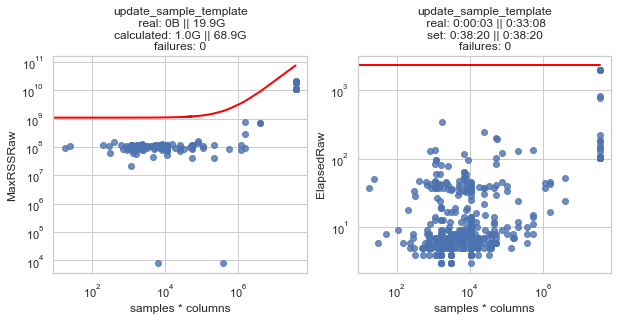

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'update_sample_template'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()
col_name = 'samples * columns'
_df[col_name] = _df.samples * _df['columns']

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (m1g)+(x_plot*2000)
_df['cMaxRSSRaw'] = (m1g)+(_df[col_name]*2000)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')


# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [2300]*len(x_plot)
_df['cElapsedRaw'] = [2300]*len(_df[col_name])
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# No changes needed! 

### Deblur 2021.09

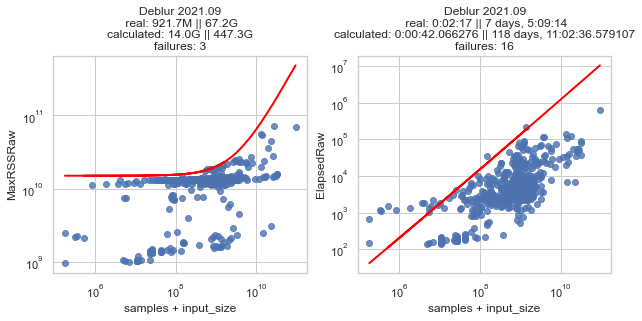

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Deblur 2021.09'
_df = df[(df.cName == cname)
          & (df.updated == 'after')
         ].copy()
col_name = 'samples + input_size'
_df[col_name] = _df.samples + _df.input_size

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (14*m1g)+(x_plot*5)
_df['cMaxRSSRaw'] = (14*m1g)+(_df[col_name]*5)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = x_plot/np.log(x_plot)/360
_df['cElapsedRaw'] = _df[col_name]/np.log(_df[col_name])/360

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (14*m1g)+(({samples}+{input_size})*5) if (14*m1g)+(({samples}+{input_size})*5) < 70*(2**30) else 70*(2**30)'
#            || '--time (({samples}+{input_size})/np.log({samples}+{input_size})/360) '
#            || 'if (({samples}+{input_size})/np.log({samples}+{input_size})/360) < 90000 else 90000'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Deblur 2021.09';

### Split libraries FASTQ

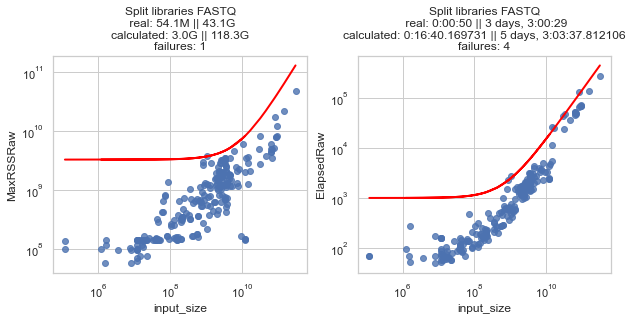

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Split libraries FASTQ'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'input_size'

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 3*m1g + (x_plot*.4)
_df['cMaxRSSRaw'] = 3*m1g +(_df[col_name]*.4)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')


# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 1000+x_plot/700000
_df['cElapsedRaw'] = 1000+_df[col_name]/700000
# 
axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# *** RESOURCE ALLOCATION ***

# UPDATE qiita.processing_job_resource_allocation set 
#     allocation = '-p qiita -N 1 -n 1 '
#            || '--mem (3*(2**30))+({input_size}*0.4) if (3*(2**30))+({input_size}*0.4) < 50*(2**30) else 50*(2**30)'
#            || '--time 1000+({input_size}/700000)'
#     WHERE job_type = 'RESOURCE_PARAMS_COMMAND' and 
#     name = 'Split libraries FASTQ';

### delete_sample_or_column

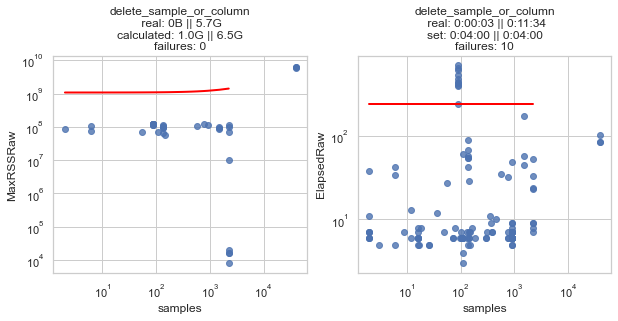

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'delete_sample_or_column'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'samples'

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = m1g+(x_plot*150000)
_df['cMaxRSSRaw'] = m1g+(_df[col_name]*150000)

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [240]*len(x_plot)
_df['cElapsedRaw'] = [240]*len(_df[col_name])

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw >= _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# No changes needed! 

### Sequence Processing Pipeline

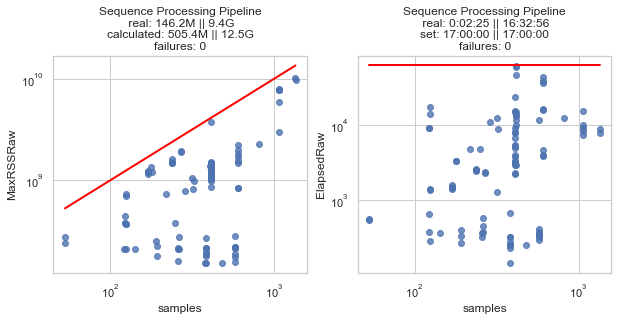

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'Sequence Processing Pipeline'
_df = df[(df.cName == cname)
          & (df.updated == 'after')
         ].copy()

col_name = 'samples'

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = (x_plot*10000000)
_df['cMaxRSSRaw'] = _df[col_name]*10000000

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')

# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = [61200]*len(x_plot)
_df['cElapsedRaw'] = [61200]*len(_df[col_name])

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'set: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# No changes needed! 

### submit_to_EBI

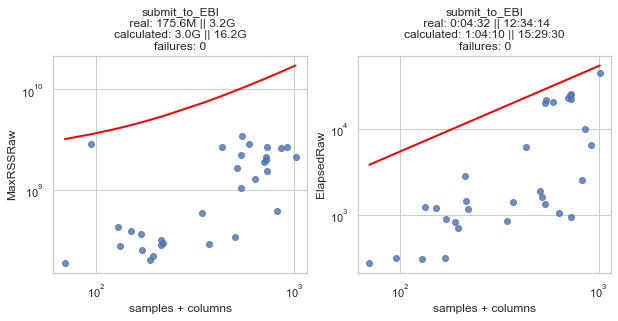

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharey=False)
fig.subplots_adjust(hspace=0.55)
sns.set(style="whitegrid")

cname = 'submit_to_EBI'
_df = df[(df.cName == cname)
#           & (df.updated == 'after')
         ].copy()

col_name = 'samples + columns'
_df[col_name] = _df['samples'] + _df['columns']

# Memory
ax = sns.regplot(x=col_name, y='MaxRSSRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False, 
                 ax=axs[0])
x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = 2*m1g+x_plot*15000000
_df['cMaxRSSRaw'] = 2*m1g+_df[col_name]*15000000

axs[0].plot(x_plot, y_plot, linewidth=2, color='red')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

max_memory = naturalsize(_df['MaxRSSRaw'].max(), gnu=True)
cmax_memory = naturalsize(max(y_plot), gnu=True)
min_memory = naturalsize(_df['MaxRSSRaw'].min(), gnu=True)
cmin_memory = naturalsize(min(y_plot), gnu=True)
failures = _df[_df.MaxRSSRaw > _df.cMaxRSSRaw]
failures = failures.shape[0]

_ = ax.set_title(f'{cname}\n real: {min_memory} || {max_memory}\n'
                 f'calculated: {cmin_memory} || {cmax_memory}\n'
                 f'failures: {failures}')
# Time
ax = sns.regplot(x=col_name, y='ElapsedRaw', 
                 data=_df,
                 x_estimator=None, 
                 fit_reg=False,
                 ax=axs[1])

x_plot = np.array(sorted(_df[col_name].unique()))
y_plot = x_plot*55
_df['cElapsedRaw'] = _df[col_name]*55

axs[1].plot(x_plot, y_plot, linewidth=2, color='red')

maxtime = timedelta(seconds=float(_df['ElapsedRaw'].max()))
cmaxtime = timedelta(seconds=float(max(y_plot)))
mintime = timedelta(seconds=float(_df['ElapsedRaw'].min()))
cmintime = timedelta(seconds=float(min(y_plot)))
failures = _df[_df.ElapsedRaw > _df.cElapsedRaw].shape[0]

_ = ax.set_title(f'{cname}\n real: {mintime} || {maxtime}\n'
                 f'calculated: {cmintime} || {cmaxtime}\n'
                 f'failures: {failures}')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# No changes needed! 